<a href="https://colab.research.google.com/github/PaoDeV99/ML_Progetto1_G72/blob/master/p1_g72_gboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Gradient Boosting Classifier**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


22/06, ore 00:03 <br/>
gbc non accetta in ingresso direttive sul decision tree classifier. Questo vuol dire niente gini (anche se dovrebbe essere impostata di default per i dtc) e niente impostazione sulla max depth (si può ovviare andando ad operare su min_samples_split, ma non sarebbe esattamente la stessa cosa). <br/>
<br/>
Il notebook presenta ancora i risultati di una run di gbc con n_estimators=1000. È stato predisposto per runnare in un ciclo comandato dal numero di stimatori, che varia secondo i valori di estimators. Va ancora impostato per bene il ciclo, prima di farlo runnare. Raccomando pazienza per quando si deciderà di farlo partire: prospetto un tempo di run abbastanza lungo, intorno ai 70 minuti. <br/>
<br/>
Vanno aggiunte delle celle che si occuppino di produrre i plot dell'accuracy al variare del numero di stimatori, così come del tempo di run (ispirati a randomforest). <br/>
<br/>
Finito il lavoro descritto sopra, puoi implementare una feature importance e vedere se e cosa cambia. <br/>
<br/>
Se hai fatto anche quello, perché non tentare la sorte con una random forest classica? O con una logistic regression? A scopo puramente accademico, sarebbe interessante vedere se la logistic regression di oggi riesce a battere il prototipo di gbc e abc.

22/06, ore 22:42 <br/>
Ho inserito la possibilità di collegare il notebook al drive, in modo da non dover ricaricare a mano il txt dei dati ad ogni sessione di lavoro. <br/>
Ho terminato la stesura del ciclo di run di gbc. È impostato per runnare con 100, 200, 500, 800 e 1000 stimatori. Vengono registragti tempo di run, training accuracy, test accuracy e confusion matrix. Ho commentato le celle relative all'impostazione precedente del notebook. <br/>
(Nota a margine: i print effettuati non sono quelli impostati nelle celle. Le modifiche, volte a favorire un'estetica migliore nei print, sono state effettuate solo dopo aver fatto partire il ciclo.)

24/06, ore 16:41 <br/>
Su suggerimento di @Zdestrion, ho aggiunto una cella di reshuffling del dataset, in modo da presentare dati relativi a rumore a segnale in quantità più simili possibile a training set e test set. I risultati cambiano di un nulla.

28/06, ore 01:13 <br/>
Ho aggiunto una regressione logistica con regolarizzazione L2. Ci sono dei problemi con il plot degli istogrammi delle probabilità delle due classi.<br/>
Cose ancora da fare:
*   Aggiungere le funzioni di plot delle accuracy e del tempo di run di gbc.
*   Aggiungere anche valori intermedi di stimatori, per avere più dati.
*   Implementare una feature importance con numero di stimatori cui risulta associata l'accuracy migliore (evidentemente 1000).
*   Provare ad operare una separazione tramite pca e tsne.



29/06, ore 00:53 <br/>
Risolto il problema del plot della regressione logistica. <br/>
Ho provato ad implementare pca e tsne. La divergenza kl non è male, ma il plot è più una macchia di rorschach che altro.

30/06, ore 23:55 <br/>
Ho aggiunto alcuni valori intermedi di *estimators* per gbc, nonché una cella dedita al plot dei risultati di gbc. <br/>
Credo che lascerò perdere pca e tsne, in fondo si tratta di classificazione, non di clustering. <br/>
Ho aggiunto una sezione sulla feature importance. <br/>

Tutti i cambiamenti effettuati oggi non sono ancora operativi, in quanto non ho effettuato ancora alcuna run. Pronostico circa due ore e mezza di run e vorrei andare a dormire.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_fwf('/content/drive/My Drive/Colab Notebooks/MiniBooNE_PID.txt')

In [4]:
df

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.167382,1.318900,0.870681,

In [5]:
df["signal"]=0
df.iloc[0:36498,50]=1
df.iloc[36499:,50]=0
df

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,signal
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487,0
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058,0
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
 x_train, x_test, y_train, y_test = train_test_split(
   df.iloc[:,0:50], df["signal"], test_size=0.33, random_state=42)

In [8]:
estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

m=len(estimators)
#n=len(leaf_size_list)

#Allocate Arrays for various quantities
gbc_train_accuracy=np.zeros((m))
gbc_test_accuracy=np.zeros((m))
run_time=np.zeros((m))

for i, nest in enumerate(estimators):
  # Define Gradient Boosting Classifier
  gbc = GradientBoostingClassifier(n_estimators=nest, min_samples_split=2, random_state=0, warm_start=True)
        
  print('n_estimators: %i'%(nest))
        
  start_time = time.time()
  gbc.fit(x_train, y_train)
  run_time[i] = time.time() - start_time    
    
  # check accuracy
  gbc_train_accuracy[i]=gbc.score(x_train,y_train)
  gbc_test_accuracy[i]=gbc.score(x_test,y_test)
  predictions = gbc.predict(x_test)
        
  result = (run_time[i], gbc_train_accuracy[i], gbc_test_accuracy[i])
  print('{0:<15}{1:<15}{2:<15}'.format("time (s)","train score", "test score"))
  print('{0:<15.4f}{1:<15.4f}{2:<15.4f}'.format(*result))
  print('\nConfusion matrix:')
  print(confusion_matrix(y_test, predictions))
  print('\n')

n_estimators: 100
time (s)       train score    test score     
208.1536       0.9329         0.9281         

Confusion matrix:
[[29411  1529]
 [ 1557 10425]]


n_estimators: 200
time (s)       train score    test score     
414.7250       0.9404         0.9345         

Confusion matrix:
[[29509  1431]
 [ 1380 10602]]


n_estimators: 300
time (s)       train score    test score     
624.0789       0.9448         0.9367         

Confusion matrix:
[[29547  1393]
 [ 1326 10656]]


n_estimators: 400
time (s)       train score    test score     
830.4862       0.9476         0.9380         

Confusion matrix:
[[29572  1368]
 [ 1292 10690]]


n_estimators: 500
time (s)       train score    test score     
1050.1420      0.9502         0.9384         

Confusion matrix:
[[29565  1375]
 [ 1270 10712]]


n_estimators: 600
time (s)       train score    test score     
1250.9281      0.9527         0.9392         

Confusion matrix:
[[29564  1376]
 [ 1235 10747]]


n_estimators: 700
time (s)  

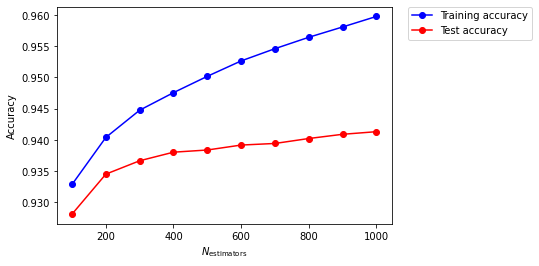

No handles with labels found to put in legend.


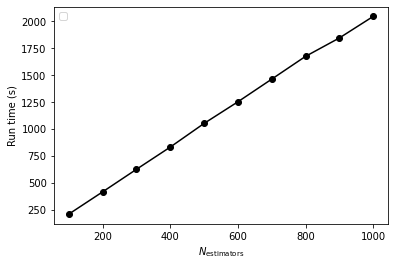

In [12]:
plt.figure()
plt.plot(estimators,gbc_train_accuracy,'o-b', label='Training accuracy')
plt.plot(estimators,gbc_test_accuracy,'o-r', label='Test accuracy')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("gbc.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(estimators, run_time, 'o-k')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
plt.savefig("runtimegbc.pdf")

plt.show()

#**Miglioriamo la ricerca dei parametri**

In [24]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"n_estimators": [100, 500, 1000],
              "learning_rate": [0.01,0.05,0.1]
             }

GBC = GradientBoostingClassifier(min_samples_split=2, random_state=0, warm_start=True)

start_time=time.time()
cv_inst = RandomizedSearchCV(GBC,
  param_distributions = param_grid,
  cv=3,
  n_iter = 10,
  n_jobs=-1)

cv_inst.fit(x_test, y_test)
print(time.time()-start_time)

7020.199124574661


In [25]:
cv_inst.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

#**Feature Importance con gbc**

In [ ]:
gbc1000 = GradientBoostingClassifier(n_estimators=1000, min_samples_split=2, random_state=0, warm_start=True)
gbc1000.fit(x_train,y_train)

In [14]:
importances = gbc1000.feature_importances_
std = np.std([gbc1000.feature_importances_ for tree in gbc1000.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('Feature by percentage of importance:\n')
for f in range(x_train.shape[1]):
  print('%d feature %d  (%f)' %(f+1, indices[f], importances[indices[f]]))

Feature by percentage of importance:

1 feature 0  (0.246452)
2 feature 16  (0.203683)
3 feature 2  (0.116827)
4 feature 1  (0.062500)
5 feature 26  (0.054832)
6 feature 31  (0.051096)
7 feature 12  (0.044844)
8 feature 3  (0.031152)
9 feature 15  (0.025965)
10 feature 22  (0.019550)
11 feature 25  (0.017069)
12 feature 17  (0.008113)
13 feature 10  (0.007845)
14 feature 27  (0.007639)
15 feature 5  (0.007452)
16 feature 13  (0.007119)
17 feature 20  (0.007083)
18 feature 42  (0.006793)
19 feature 4  (0.006723)
20 feature 6  (0.005103)
21 feature 36  (0.004704)
22 feature 8  (0.004531)
23 feature 29  (0.004370)
24 feature 11  (0.004237)
25 feature 38  (0.004198)
26 feature 9  (0.004029)
27 feature 19  (0.003286)
28 feature 23  (0.003209)
29 feature 24  (0.003150)
30 feature 37  (0.002576)
31 feature 30  (0.001914)
32 feature 45  (0.001883)
33 feature 47  (0.001879)
34 feature 41  (0.001770)
35 feature 40  (0.001622)
36 feature 34  (0.001395)
37 feature 39  (0.001361)
38 feature 33  (0.

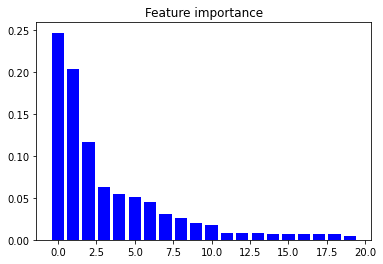

In [18]:
#Grafichiamo l'istogramma delle featue importances, ponendo come indice sull'asse
#delle ascisse la posizione nella classifica delle feature più preponderanti
plt.figure()
plt.title('Feature importance')
#plt.bar(range(x_train.shape[1]), importances[indices], color='b')
plt.bar(range(0, 20), importances[indices[:20]], color='b')

plt.show()

#**Regressione logistica**

In [22]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV()

start_time = time.time()
logreg.fit(x_train, y_train)
logreg_runtime = time.time() - start_time
logregacc = logreg.score(x_test, y_test)
logregpred = logreg.predict(x_test)

logreg_result = (logreg_runtime, logregacc)
print('{0:<15}{1:<15}'.format("time (s)", "test score"))
print('{0:<15.4f}{1:<15.4f}'.format(*logreg_result))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, logregpred))

time (s)       test score     
186.2340       0.8942         

Confusion matrix:
[[29289  1651]
 [ 2891  9091]]


In [20]:
logreg_prob = logreg.predict_proba(x_test)
print(logreg_prob)

[[0.98732999 0.01267001]
 [0.90191882 0.09808118]
 [0.98839831 0.01160169]
 ...
 [0.95504728 0.04495272]
 [0.99521577 0.00478423]
 [0.00436633 0.99563367]]


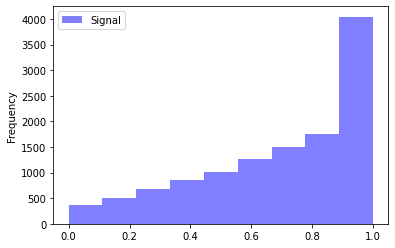

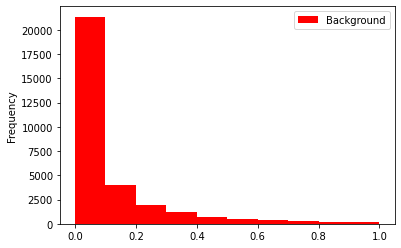

In [21]:
# grafico delle probabilità delle due classi:
y_test = pd.Series(y_test).values
df_test_acc = pd.DataFrame({'PROB':logreg_prob[:,1]})
df_test_acc['SIG'] = y_test

df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

#**PCA e TSNE**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seed=12345

In [ ]:
np.random.seed(seed)
rndperm = np.random.permutation(df.shape[0])

# selezioniamo i primi 10k eventi dal dataframe 
N = 50000
df_subset = df.loc[rndperm[:N],:].copy()
df_copy=df_subset
df_subset = df_subset.drop(columns= 'signal')
columns=["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

data_subset = df_subset.values

pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(data_subset)
print('Cumulative explained variation for 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result_10)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df_subset['tsne-pca10-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca10-two'] = tsne_pca_results[:,1]
df_subset['signal'] = df_copy['signal']
ax4=df_subset.plot.scatter(x="tsne-pca10-one", y="tsne-pca10-two", c='signal', colormap='tab10',figsize=(8,8))